In [1]:
from tomoSegmentPipeline.utils.common import read_array, write_array
from tomoSegmentPipeline.utils import setup

from cryoS2Sdrop.dataloader import singleCET_dataset, singleCET_FourierDataset, singleCET_ProjectedDataset
from cryoS2Sdrop.model import Denoising_3DUNet, Denoising_3DUNet_v2
from cryoS2Sdrop.losses import self2self_L2Loss
from cryoS2Sdrop.trainer import denoisingTrainer
from cryoS2Sdrop.predict import load_model, predict_full_tomogram

import yaml
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from glob import glob

from torchsummary import summary
from pytorch_lightning import Trainer
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor

PARENT_PATH = setup.PARENT_PATH
ISONET_PATH = os.path.join(PARENT_PATH, 'data/isoNet/')

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
version = 'version_3'
# logdir = os.path.join(PARENT_PATH, 'data/S2SDenoising/tryout_model_logs/model9/dataset_alpha_comparison/%s/' %version)
logdir = os.path.join(PARENT_PATH, 'data/S2SDenoising/tryout_model_logs/model9/none/%s/' %version)
# logdir = os.path.join(PARENT_PATH, 'data/S2SDenoising/model_logs/%s/' %version)

model, hparams = load_model(logdir, Denoising_3DUNet_v2, DataParallel=True)

cet_path = hparams['tomo_path']
p = float(hparams['p']) # dropout (zeroing) probability
subtomo_length = int(hparams['subtomo_length'])
n_features = int(hparams['n_features'])

In [3]:
# my_dataset = singleCET_dataset(cet_path, subtomo_length, p=p, n_bernoulli_samples=20)
# my_dataset = singleCET_FourierDataset(cet_path, subtomo_length, p=p, n_bernoulli_samples=30)
my_dataset = singleCET_ProjectedDataset(cet_path, subtomo_length, gt_tomo_path=hparams['gt_tomo_path'])
len(my_dataset)

64

In [35]:
# plt.figure(figsize=(12, 8))
# plt.imshow(my_dataset.simRecon0[my_dataset.tomo_shape[0]//2])

# Single subtomo prediction

## Type 1: one averaged prediction from N bernoulli samples

In [36]:
subtomo, target, mask = my_dataset[0]
subtomo, target, mask = subtomo.unsqueeze(0), target.unsqueeze(0), mask.unsqueeze(0) 
subtomo.shape

torch.Size([1, 1, 128, 128, 128])

In [37]:
denoised_subtomo = model(subtomo).squeeze().cpu().detach().numpy()
denoised_subtomo.shape

(128, 128, 128)

In [38]:
original_subtomo = (target + subtomo).squeeze().detach().numpy()
original_subtomo.shape

(128, 128, 128)

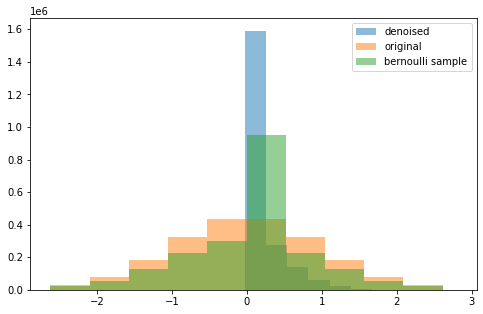

In [39]:
plt.figure(figsize=(8, 5))
plt.hist(denoised_subtomo.flatten(), alpha=0.5, label='denoised')
plt.hist(original_subtomo.flatten(), alpha=0.5, label='original')
plt.hist(subtomo.squeeze().flatten().numpy(), alpha=0.5, label='bernoulli sample')
plt.legend()

Text(0.5, 1.0, 'Input')

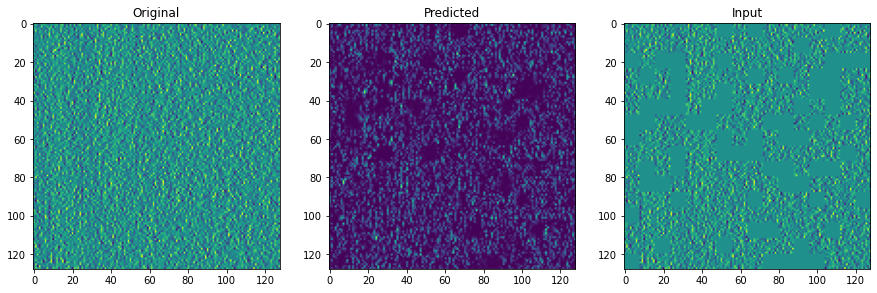

In [40]:
zidx = subtomo_length//2

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 10))
ax0.imshow(original_subtomo[zidx])
ax0.set_title('Original')
ax1.imshow(denoised_subtomo[zidx])
ax1.set_title('Predicted')
ax2.imshow(subtomo.squeeze()[zidx])
ax2.set_title('Input')

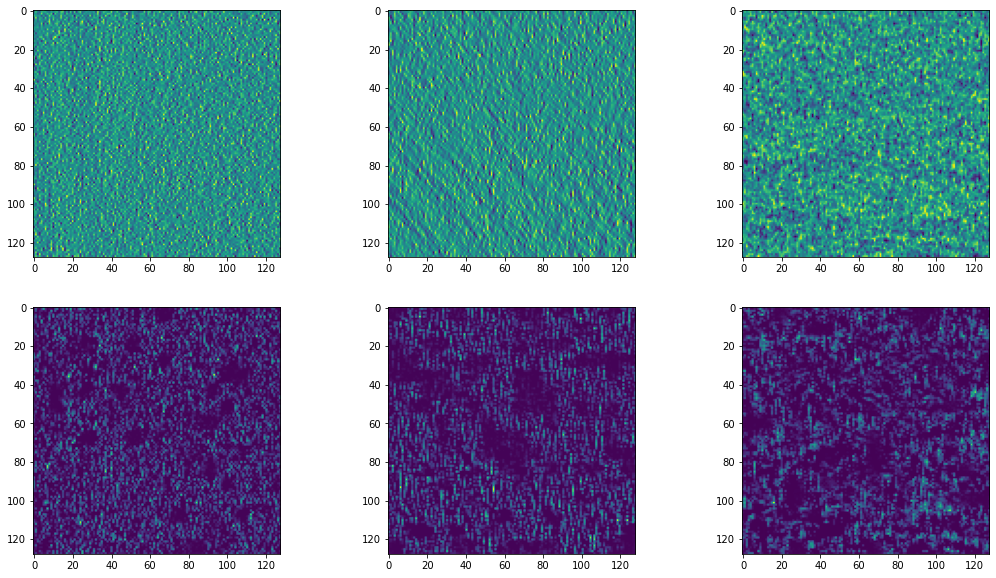

In [42]:
aux_idx = subtomo_length//2

fig, (ax0, ax1) = plt.subplots(2, 3, figsize=(18, 10))

ax0[0].imshow(original_subtomo[aux_idx])
ax0[1].imshow(original_subtomo[:, aux_idx, :])
ax0[2].imshow(original_subtomo[:, :, aux_idx])

ax1[0].imshow(denoised_subtomo[aux_idx])
ax1[1].imshow(denoised_subtomo[:, aux_idx, :])
ax1[2].imshow(denoised_subtomo[:, :, aux_idx])

## Type 2: one averaged prediction from N model predictions on a single bernoulli sample

In [44]:
subtomo, target, mask = my_dataset[18]
# subtomo, target, mask = subtomo.unsqueeze(0), target.unsqueeze(0), mask.unsqueeze(0) 
subtomo.shape

torch.Size([1, 64, 64, 64])

In [45]:
def aux_forward(model):
    with torch.no_grad():
        subtomo = my_dataset[10][0]
        subtomo = subtomo.unsqueeze(0) 
        return model(subtomo)

In [46]:
denoised_subtomo = torch.stack([aux_forward(model) for i in range(1)]).mean((0, 1)).squeeze().cpu().detach().numpy()
denoised_subtomo.shape

(64, 64, 64)

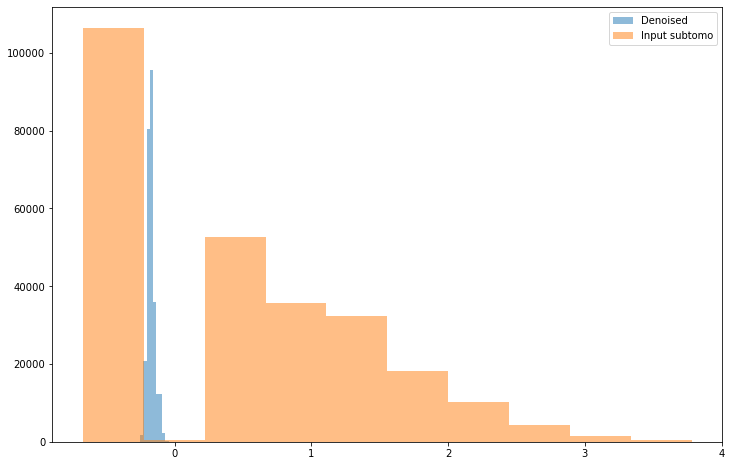

In [47]:
plt.figure(figsize=(12, 8))
plt.hist(denoised_subtomo.flatten(), alpha = 0.5, label='Denoised')
plt.hist(subtomo.numpy().flatten(), alpha = 0.5, label='Input subtomo')
plt.legend()

In [48]:
original_subtomo = (target)[0].squeeze().detach().numpy()
original_subtomo.shape

(64, 64, 64)

Text(0.5, 1.0, 'Input')

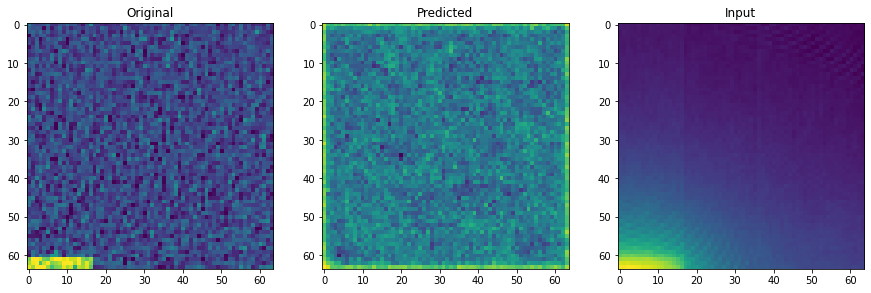

In [49]:
zidx = subtomo_length//2

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 10))
ax0.imshow(original_subtomo[zidx])
ax0.set_title('Original')
ax1.imshow(denoised_subtomo[zidx])
ax1.set_title('Predicted')
ax2.imshow(subtomo[0].squeeze()[zidx])
ax2.set_title('Input')

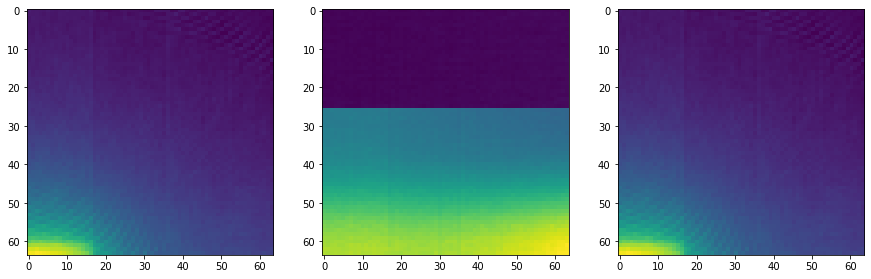

In [50]:
aux_idx = subtomo_length//2
# aux_idx = 0

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 10))

ax0.imshow(subtomo[0].squeeze()[aux_idx])
ax1.imshow(subtomo[0].squeeze()[:, aux_idx, :])
ax2.imshow(subtomo[0].squeeze()[aux_idx, :, :])

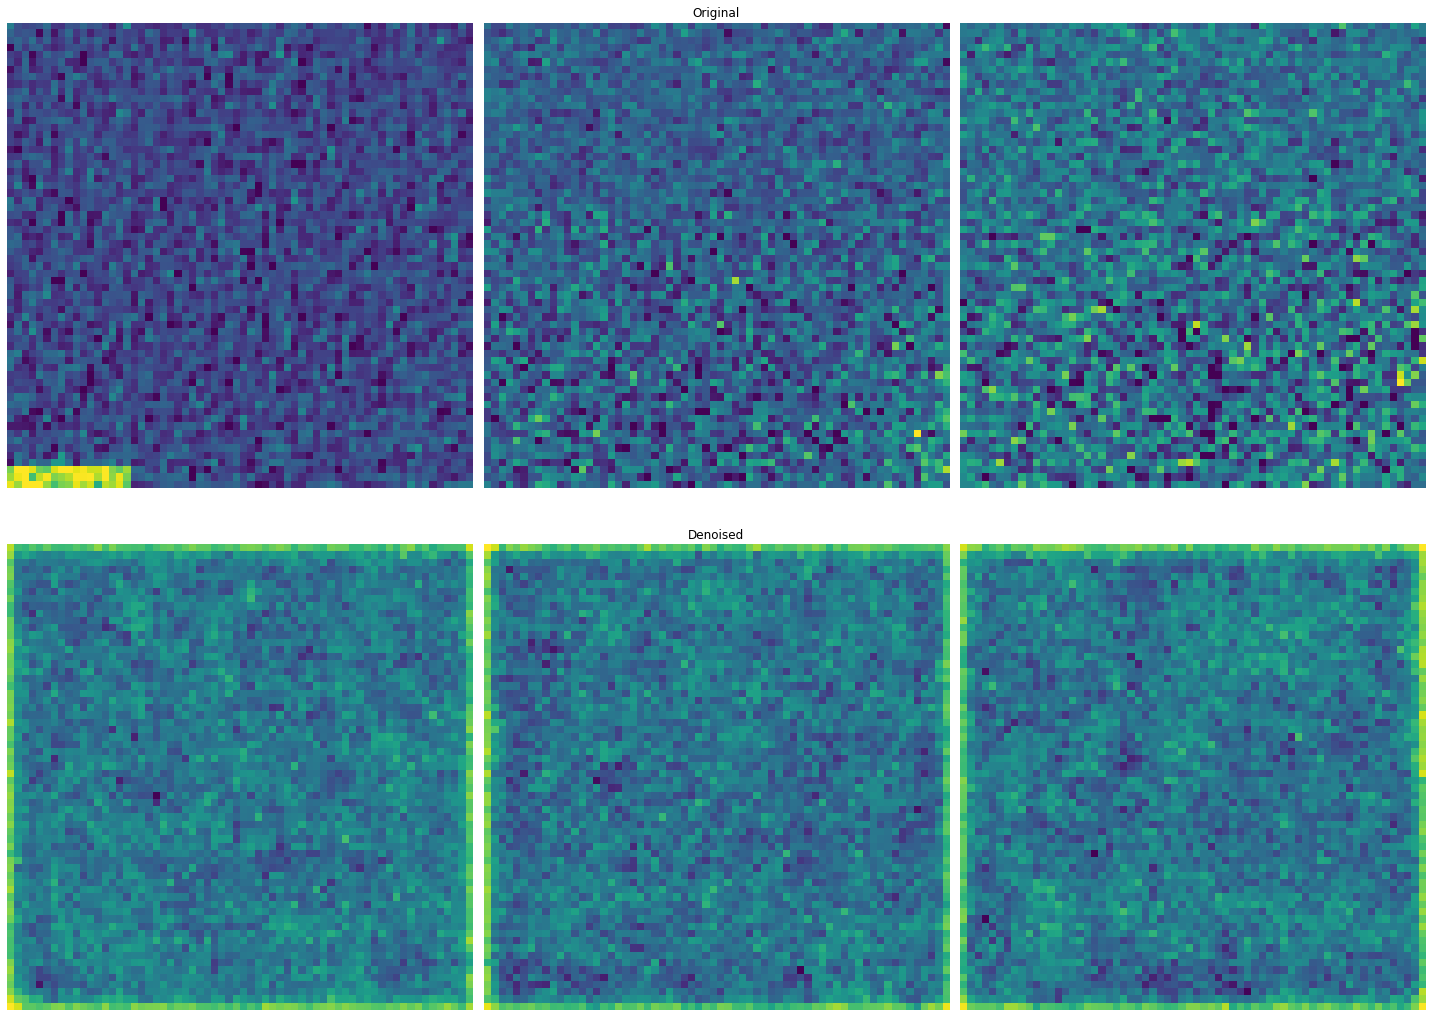

In [51]:
aux_idx = subtomo_length//2

fig, (ax0, ax1) = plt.subplots(2, 3, figsize=(20, 15))
list(map(lambda axi: axi.set_axis_off(), np.array([ax0, ax1]).ravel()))

ax0[1].set_title('Original')
ax0[0].imshow(original_subtomo[aux_idx])
ax0[1].imshow(original_subtomo[:, aux_idx, :])
ax0[2].imshow(original_subtomo[:, :, aux_idx])

ax1[1].set_title('Denoised')
ax1[0].imshow(denoised_subtomo[aux_idx])
ax1[1].imshow(denoised_subtomo[:, aux_idx, :])
ax1[2].imshow(denoised_subtomo[:, :, aux_idx])

plt.tight_layout()

# Full tomogram prediction

## Pilot

In [39]:
denoised_tomo = torch.zeros_like(my_dataset.data)
count_tensor = torch.zeros_like(my_dataset.data)

for i in tqdm(range(10)):
    for idx, p0 in enumerate(my_dataset.grid):
        zmin, ymin, xmin = np.array(p0)-subtomo_length//2
        zmax, ymax, xmax = np.array(p0)+subtomo_length//2
        subtomo = my_dataset[idx][0]
        pred = model(subtomo).squeeze().detach().cpu()
        denoised_tomo[zmin:zmax, ymin:ymax, xmin:xmax] += pred
        count_tensor[zmin:zmax, ymin:ymax, xmin:xmax] += 1
    
denoised_tomo = denoised_tomo / count_tensor

  0%|                                                | 0/10 [00:01<?, ?it/s]


RuntimeError: output with shape [96, 96, 96] doesn't match the broadcast shape [6, 96, 96, 96]

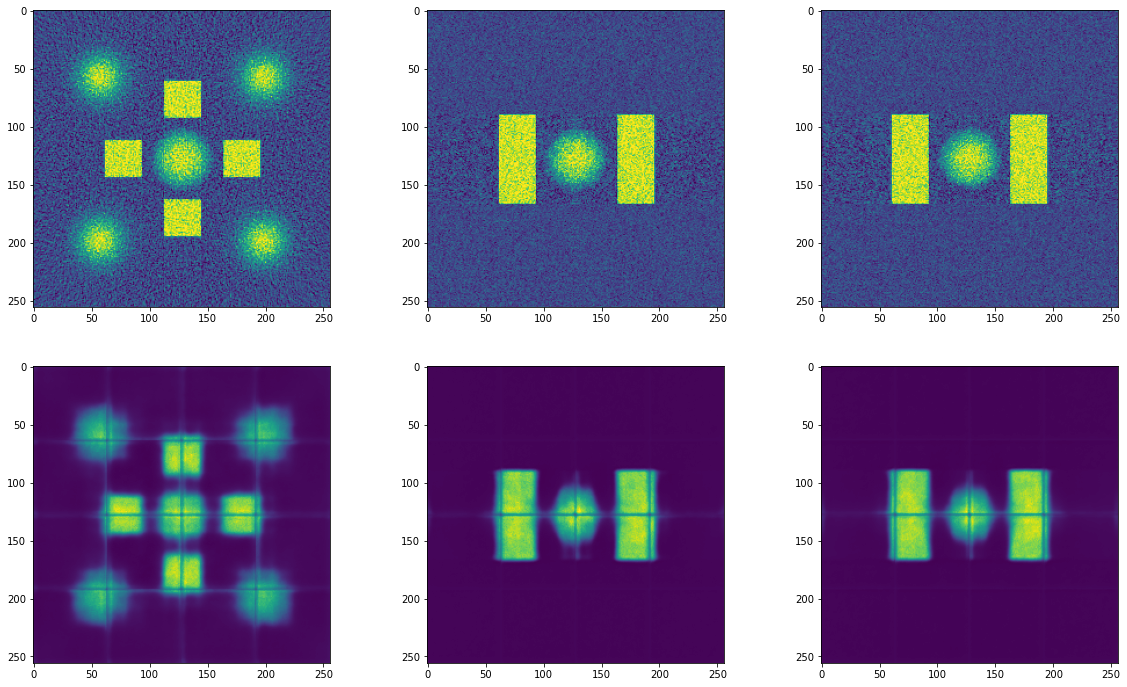

In [13]:
aux_idx = np.array(my_dataset.data.shape)[0]//2
# aux_idx = subtomo_length//8

fig, (ax0, ax1) = plt.subplots(2, 3, figsize=(20, 12))

ax0[0].imshow(my_dataset.data[aux_idx])
ax0[1].imshow(my_dataset.data[:, aux_idx, :])
ax0[2].imshow(my_dataset.data[:, :, aux_idx])

ax1[0].imshow(denoised_tomo[aux_idx])
ax1[1].imshow(denoised_tomo[:, aux_idx, :])
ax1[2].imshow(denoised_tomo[:, :, aux_idx])

## Code in predict.py

In [51]:
torch.cuda.empty_cache()

In [10]:
denoised_tomo = predict_full_tomogram(my_dataset, model, N=25)

100%|███████████████████████████████████████| 64/64 [00:58<00:00,  1.10it/s]


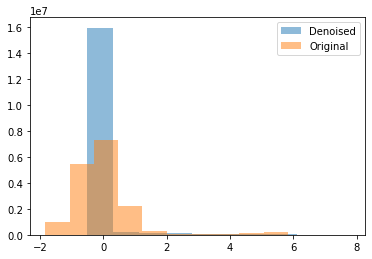

In [11]:
plt.hist(denoised_tomo.numpy().flatten(), alpha=0.5, label='Denoised')
plt.hist(my_dataset.data.numpy().flatten(), alpha=0.5, label='Original')
plt.legend()

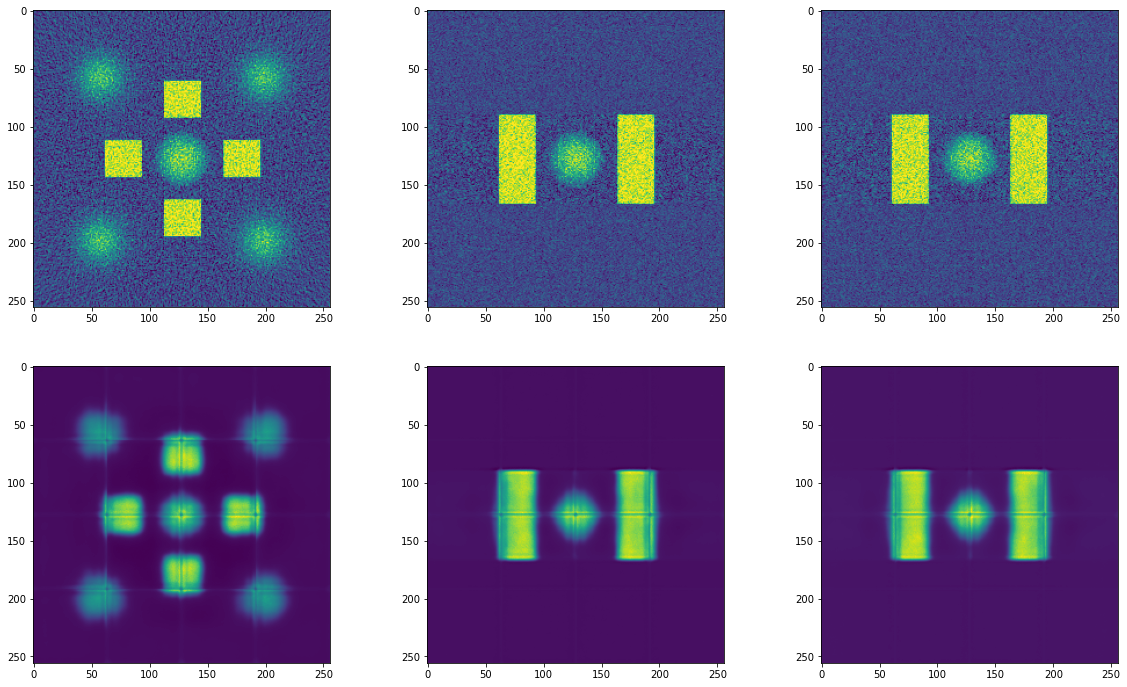

In [12]:
# aux_idx = subtomo_length//2
aux_idx = 116
# aux_idx = subtomo_length//8

fig, (ax0, ax1) = plt.subplots(2, 3, figsize=(20, 12))

ax0[0].imshow(my_dataset.data[aux_idx])
ax0[1].imshow(my_dataset.data[:, aux_idx, :])
ax0[2].imshow(my_dataset.data[:, :, aux_idx])

ax1[0].imshow(denoised_tomo[aux_idx])
ax1[1].imshow(denoised_tomo[:, aux_idx, :])
ax1[2].imshow(denoised_tomo[:, :, aux_idx])

In [55]:
# filename = cet_path.split('/')[-1].replace('.mrc', '_s2sDenoised')
# v = version.replace('version_', 'v')
# filename = os.path.join(PARENT_PATH, 'data/S2SDenoising/denoised/%s_%s.mrc' %(filename, v))

# write_array(denoised_tomo.numpy(), filename)